In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import tensorflow as tf
keras = tf.keras

2023-09-16 23:53:38.723178: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


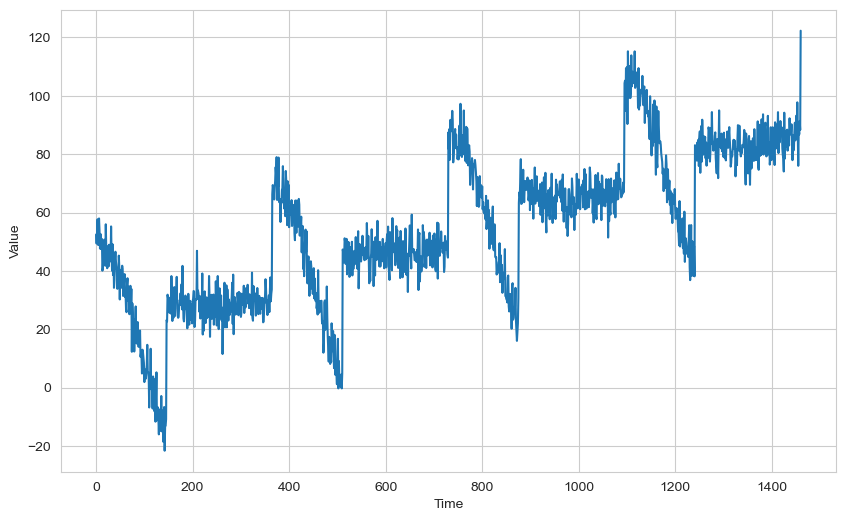

In [2]:
def plot_series(time,series,format="-",start=0,end=None,label=None):
    plt.plot(time[start:end], series[start:end],format,label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

def trend(time,slope=0):
    return slope*time
    
#seasonal Data
def seasonal_pattern(season_time):
    return np.where(season_time< 0.4,np.cos(season_time*2*np.pi),
                   1/np.exp(3*season_time))

def seasonality(time,period,amplitude=1,phase=0):
    season_time = ((time+phase)%period)/period
    return amplitude*seasonal_pattern(season_time)

# noise
def white_noise(time,noise_level=1,seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4*365+1)
slope = 0.05
baseline = 10
amplitude = 40

series = baseline+trend(time,slope)+seasonality(time,period=365,amplitude=amplitude)
noise_level = 5
noise = white_noise(time,noise_level,seed=42)
series += noise

plt.figure(figsize=(10,6))
plot_series(time,series)
plt.show()

In [3]:
def sequential_window_dataset(series,window_size):
    series = tf.expand_dims(series,axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size+1,shift=window_size,drop_remainder=True)
    ds = ds.flat_map(lambda window:window.batch(window_size+1))
    ds = ds.map(lambda window:(window[:-1],window[1:]))
    return ds.batch(1).prefetch(1)

In [4]:
split_time = 1000
time_train = time[:split_time]
X_train = series[:split_time]
time_valid = time[split_time:]
X_valid = series[split_time:]

In [5]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
window_size = 30

In [6]:
train_set = sequential_window_dataset(X_train,window_size)

2023-09-16 23:54:55.280858: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
model = keras.models.Sequential([
    keras.layers.LSTM(100,return_sequences=True,stateful=True,batch_input_shape=[1,None,1]),
    keras.layers.LSTM(100,return_sequences=True,stateful=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x*200.0)
])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (1, None, 100)            40800     
                                                                 
 lstm_1 (LSTM)               (1, None, 100)            80400     
                                                                 
 dense (Dense)               (1, None, 1)              101       
                                                                 
 lambda (Lambda)             (1, None, 1)              0         
                                                                 
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________


In [9]:
lr_schedule = keras.callbacks.LearningRateScheduler(
lambda epoch: 1e-8*10**(epoch/20))

In [10]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self,epoch,logs):
        self.model.reset_states()

In [11]:
reset_states = ResetStatesCallback()

In [12]:
optimizer = keras.optimizers.SGD(learning_rate=1e-8,momentum=0.9)
model.compile(loss=keras.losses.Huber(),optimizer=optimizer,metrics=['mae'])

In [13]:
history = model.fit(train_set,epochs=100,callbacks=[lr_schedule,reset_states])

Epoch 1/100
33/33 [==============================] - 4s 38ms/step - loss: 18.1751 - mae: 18.6696 - lr: 1.0000e-08
Epoch 2/100
33/33 [==============================] - 0s 11ms/step - loss: 16.3323 - mae: 16.8256 - lr: 1.1220e-08
Epoch 3/100
33/33 [==============================] - 0s 12ms/step - loss: 15.1267 - mae: 15.6188 - lr: 1.2589e-08
Epoch 4/100
33/33 [==============================] - 0s 12ms/step - loss: 14.4642 - mae: 14.9562 - lr: 1.4125e-08
Epoch 5/100
33/33 [==============================] - 0s 11ms/step - loss: 14.0599 - mae: 14.5504 - lr: 1.5849e-08
Epoch 6/100
33/33 [==============================] - 0s 11ms/step - loss: 13.7205 - mae: 14.2096 - lr: 1.7783e-08
Epoch 7/100
33/33 [==============================] - 0s 11ms/step - loss: 13.3819 - mae: 13.8706 - lr: 1.9953e-08
Epoch 8/100
33/33 [==============================] - 0s 11ms/step - loss: 13.0153 - mae: 13.5040 - lr: 2.2387e-08
Epoch 9/100
33/33 [==============================] - 0s 11ms/step - loss: 12.6064 - mae:

33/33 [==============================] - 0s 11ms/step - loss: 24.1451 - mae: 24.6406 - lr: 3.9811e-05
Epoch 74/100
33/33 [==============================] - 0s 12ms/step - loss: 10.0292 - mae: 10.5172 - lr: 4.4668e-05
Epoch 75/100
33/33 [==============================] - 0s 14ms/step - loss: 13.6792 - mae: 14.1711 - lr: 5.0119e-05
Epoch 76/100
33/33 [==============================] - 0s 14ms/step - loss: 9.1894 - mae: 9.6781 - lr: 5.6234e-05
Epoch 77/100
33/33 [==============================] - 0s 12ms/step - loss: 9.7406 - mae: 10.2274 - lr: 6.3096e-05
Epoch 78/100
33/33 [==============================] - 0s 11ms/step - loss: 12.1060 - mae: 12.5943 - lr: 7.0795e-05
Epoch 79/100
33/33 [==============================] - 0s 11ms/step - loss: 10.4799 - mae: 10.9701 - lr: 7.9433e-05
Epoch 80/100
33/33 [==============================] - 0s 11ms/step - loss: 12.2207 - mae: 12.7084 - lr: 8.9125e-05
Epoch 81/100
33/33 [==============================] - 0s 11ms/step - loss: 11.9474 - mae: 12.439

(1e-08, 0.0001, 0.0, 30.0)

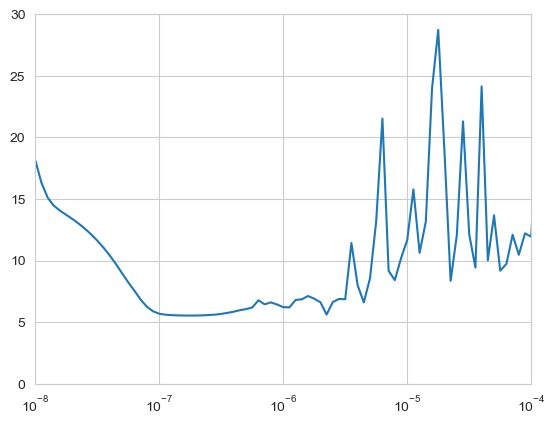

In [14]:
plt.semilogx(history.history['lr'],history.history['loss'])
plt.axis([1e-8,1e-4,0,30])

In [15]:
# Second
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [16]:
window_size = 30
train_set = sequential_window_dataset(X_train,window_size)
valid_set = sequential_window_dataset(X_valid,window_size)

In [17]:
model = keras.models.Sequential([
    keras.layers.LSTM(100,return_sequences=True,stateful=True,batch_input_shape=[1,None,1]),
    keras.layers.LSTM(100,return_sequences=True,stateful=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x*200.0)
])

In [18]:
optimizer = keras.optimizers.SGD(learning_rate=1e-5,momentum=0.9)
model.compile(loss=keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

In [19]:
reset_states = ResetStatesCallback()

In [20]:
model_checkpoint = keras.callbacks.ModelCheckpoint("my_checkpoint.h5",save_best_only=True)

In [21]:
early_stopping = keras.callbacks.EarlyStopping(patience=50)

In [22]:
model.fit(train_set,epochs=500,
         validation_data=valid_set,callbacks=[early_stopping,model_checkpoint,reset_states])

Epoch 1/500
33/33 [==============================] - 4s 39ms/step - loss: 27.6390 - mae: 28.1337 - val_loss: 10.9938 - val_mae: 11.4876
Epoch 2/500
33/33 [==============================] - 0s 13ms/step - loss: 12.3926 - mae: 12.8860 - val_loss: 15.0401 - val_mae: 15.5384
Epoch 3/500
33/33 [==============================] - 0s 14ms/step - loss: 12.5822 - mae: 13.0706 - val_loss: 7.8936 - val_mae: 8.3789
Epoch 4/500
33/33 [==============================] - 0s 14ms/step - loss: 12.2020 - mae: 12.6922 - val_loss: 15.3214 - val_mae: 15.8195
Epoch 5/500
33/33 [==============================] - 0s 14ms/step - loss: 20.0795 - mae: 20.5733 - val_loss: 7.1465 - val_mae: 7.6333
Epoch 6/500
33/33 [==============================] - 0s 13ms/step - loss: 10.9122 - mae: 11.4045 - val_loss: 18.8391 - val_mae: 19.3387
Epoch 7/500
33/33 [==============================] - 0s 14ms/step - loss: 10.0820 - mae: 10.5717 - val_loss: 7.5219 - val_mae: 8.0108
Epoch 8/500
33/33 [==============================] - 0

33/33 [==============================] - 1s 16ms/step - loss: 5.6986 - mae: 6.1840 - val_loss: 6.2016 - val_mae: 6.6805
Epoch 63/500
33/33 [==============================] - 1s 15ms/step - loss: 5.1693 - mae: 5.6479 - val_loss: 6.1141 - val_mae: 6.5947
Epoch 64/500
33/33 [==============================] - 0s 15ms/step - loss: 5.7429 - mae: 6.2277 - val_loss: 6.5176 - val_mae: 6.9986
Epoch 65/500
33/33 [==============================] - 0s 15ms/step - loss: 5.6769 - mae: 6.1591 - val_loss: 8.2548 - val_mae: 8.7392
Epoch 66/500
33/33 [==============================] - 0s 13ms/step - loss: 5.4321 - mae: 5.9110 - val_loss: 8.4925 - val_mae: 8.9790
Epoch 67/500
33/33 [==============================] - 0s 14ms/step - loss: 5.8071 - mae: 6.2918 - val_loss: 8.8796 - val_mae: 9.3718
Epoch 68/500
33/33 [==============================] - 0s 13ms/step - loss: 5.2440 - mae: 5.7249 - val_loss: 7.7384 - val_mae: 8.2208
Epoch 69/500
33/33 [==============================] - 0s 13ms/step - loss: 5.7469 

33/33 [==============================] - 0s 14ms/step - loss: 7.1460 - mae: 7.6356 - val_loss: 7.9053 - val_mae: 8.3910
Epoch 124/500
33/33 [==============================] - 0s 13ms/step - loss: 6.3756 - mae: 6.8620 - val_loss: 8.8691 - val_mae: 9.3597
Epoch 125/500
33/33 [==============================] - 0s 13ms/step - loss: 5.8276 - mae: 6.3103 - val_loss: 8.7299 - val_mae: 9.2199
Epoch 126/500
33/33 [==============================] - 0s 13ms/step - loss: 5.5288 - mae: 6.0107 - val_loss: 8.3886 - val_mae: 8.8754
Epoch 127/500
33/33 [==============================] - 0s 14ms/step - loss: 5.6403 - mae: 6.1240 - val_loss: 12.4750 - val_mae: 12.9704
Epoch 128/500
33/33 [==============================] - 1s 17ms/step - loss: 6.0013 - mae: 6.4863 - val_loss: 11.0005 - val_mae: 11.4956
Epoch 129/500
33/33 [==============================] - 0s 14ms/step - loss: 5.6317 - mae: 6.1129 - val_loss: 14.3987 - val_mae: 14.8924
Epoch 130/500
33/33 [==============================] - 0s 13ms/step - 

In [23]:
model = keras.models.load_model("my_checkpoint.h5")

In [24]:
rnn_forecast = model.predict(series[np.newaxis, : ,np.newaxis])

1/1 [==============================] - 1s 939ms/step


In [25]:
rnn_forecast = rnn_forecast[0,split_time-1:-1,0]

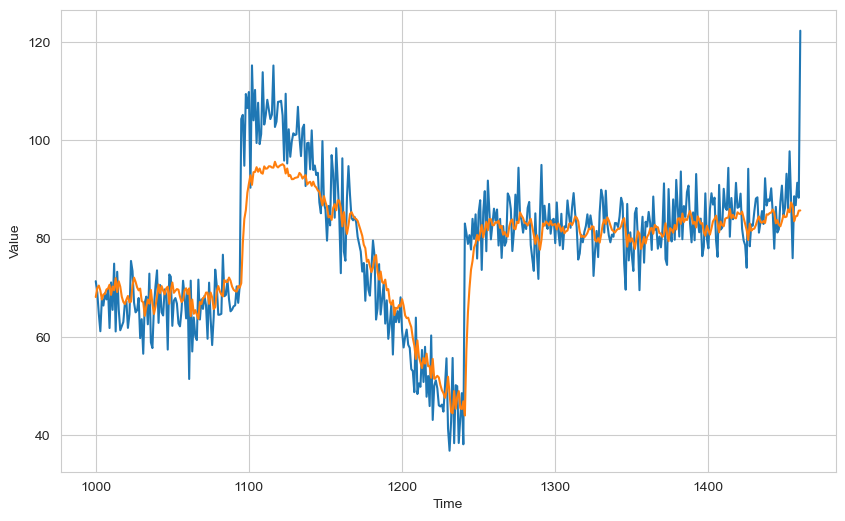

In [26]:
plt.figure(figsize=(10,6))
plot_series(time_valid,X_valid)
plot_series(time_valid,rnn_forecast)

### Forecasting With CNN

In [27]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
window_size = 30


def seq2_seq_window_dataset(series,window_size,batch_size=32,shuffle_buffer=1000):
    series = tf.expand_dims(series,axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size+1,shift=1,drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size+1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1],w[1:]))
    return ds.batch(batch_size).prefetch(1)


train_set = seq2_seq_window_dataset(X_train,window_size,batch_size=128)

In [28]:
model = keras.models.Sequential([
    keras.layers.Conv1D(filters=32,kernel_size=5,strides=1,padding='causal',activation='relu',input_shape=[None,1]),
    keras.layers.LSTM(32,return_sequences=True),
    keras.layers.LSTM(32,return_sequences=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x*200),
])

In [29]:
lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8*10**(epoch/20))

In [30]:
optimizer = keras.optimizers.SGD(learning_rate=1e-8,momentum=0.9)
model.compile(loss=keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

In [31]:
history = model.fit(train_set,epochs=100,callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 3s 31ms/step - loss: 27.0984 - mae: 27.5947 - lr: 1.0000e-08
Epoch 2/100
8/8 [==============================] - 0s 27ms/step - loss: 26.6518 - mae: 27.1479 - lr: 1.1220e-08
Epoch 3/100
8/8 [==============================] - 0s 28ms/step - loss: 25.9886 - mae: 26.4845 - lr: 1.2589e-08
Epoch 4/100
8/8 [==============================] - 0s 29ms/step - loss: 25.2844 - mae: 25.7801 - lr: 1.4125e-08
Epoch 5/100
8/8 [==============================] - 0s 27ms/step - loss: 24.6000 - mae: 25.0960 - lr: 1.5849e-08
Epoch 6/100
8/8 [==============================] - 0s 26ms/step - loss: 23.9734 - mae: 24.4692 - lr: 1.7783e-08
Epoch 7/100
8/8 [==============================] - 0s 25ms/step - loss: 23.4157 - mae: 23.9116 - lr: 1.9953e-08
Epoch 8/100
8/8 [==============================] - 0s 26ms/step - loss: 22.9279 - mae: 23.4240 - lr: 2.2387e-08
Epoch 9/100
8/8 [==============================] - 0s 29ms/step - loss: 22.4989 - mae: 22.9943 - lr: 2.5

8/8 [==============================] - 0s 27ms/step - loss: 6.6186 - mae: 7.1018 - lr: 4.4668e-05
Epoch 75/100
8/8 [==============================] - 0s 30ms/step - loss: 6.2437 - mae: 6.7274 - lr: 5.0119e-05
Epoch 76/100
8/8 [==============================] - 0s 30ms/step - loss: 6.6048 - mae: 7.0890 - lr: 5.6234e-05
Epoch 77/100
8/8 [==============================] - 0s 36ms/step - loss: 6.9924 - mae: 7.4780 - lr: 6.3096e-05
Epoch 78/100
8/8 [==============================] - 0s 31ms/step - loss: 7.2719 - mae: 7.7577 - lr: 7.0795e-05
Epoch 79/100
8/8 [==============================] - 0s 26ms/step - loss: 8.7132 - mae: 9.2012 - lr: 7.9433e-05
Epoch 80/100
8/8 [==============================] - 0s 28ms/step - loss: 7.6921 - mae: 8.1784 - lr: 8.9125e-05
Epoch 81/100
8/8 [==============================] - 0s 28ms/step - loss: 7.5538 - mae: 8.0408 - lr: 1.0000e-04
Epoch 82/100
8/8 [==============================] - 0s 35ms/step - loss: 7.3218 - mae: 7.8076 - lr: 1.1220e-04
Epoch 83/100
8

(1e-08, 0.0001, 0.0, 30.0)

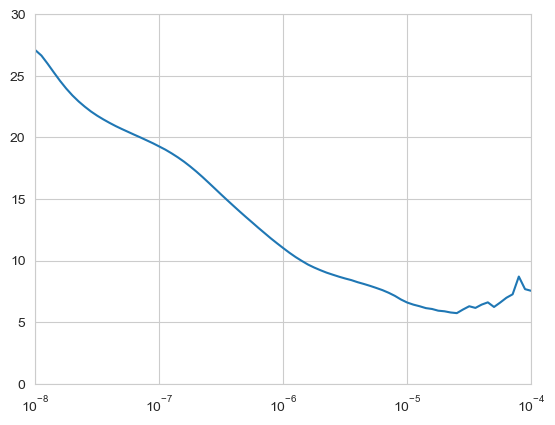

In [32]:
plt.semilogx(history.history['lr'],history.history['loss'])
plt.axis([1e-8,1e-4,0,30])

In [33]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
window_size = 30

In [34]:
window_size = 30

In [35]:
train_set = seq2_seq_window_dataset(X_train,window_size,batch_size=128)
valid_set = seq2_seq_window_dataset(X_valid,window_size,batch_size=128)

In [36]:
model = keras.models.Sequential([
    keras.layers.Conv1D(filters=32,kernel_size=5,strides=1,padding='causal',activation='relu',input_shape=[None,1]),
    keras.layers.LSTM(32,return_sequences=True),
    keras.layers.LSTM(32,return_sequences=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x*200),
])

In [37]:
optimizer = keras.optimizers.SGD(learning_rate=1e-5,momentum=0.9)
model.compile(loss=keras.losses.Huber(),optimizer=optimizer,
             metrics=['mae'])

In [38]:
model_checkpoint = keras.callbacks.ModelCheckpoint("my_checkpoint.h5",save_best_only=True)

In [39]:
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set,epochs=500,validation_data=valid_set,
         callbacks=[early_stopping,model_checkpoint])

Epoch 1/500
8/8 [==============================] - 5s 153ms/step - loss: 57.6578 - mae: 58.1552 - val_loss: 24.7684 - val_mae: 25.2658
Epoch 2/500
8/8 [==============================] - 0s 41ms/step - loss: 21.8597 - mae: 22.3544 - val_loss: 29.1105 - val_mae: 29.6087
Epoch 3/500
8/8 [==============================] - 0s 41ms/step - loss: 14.7215 - mae: 15.2141 - val_loss: 33.3110 - val_mae: 33.8101
Epoch 4/500
8/8 [==============================] - 0s 45ms/step - loss: 10.1879 - mae: 10.6761 - val_loss: 23.1416 - val_mae: 23.6400
Epoch 5/500
8/8 [==============================] - 0s 44ms/step - loss: 8.0092 - mae: 8.4954 - val_loss: 18.6259 - val_mae: 19.1225
Epoch 6/500
8/8 [==============================] - 0s 45ms/step - loss: 7.4629 - mae: 7.9487 - val_loss: 17.2428 - val_mae: 17.7384
Epoch 7/500
8/8 [==============================] - 0s 46ms/step - loss: 7.0041 - mae: 7.4887 - val_loss: 15.8577 - val_mae: 16.3520
Epoch 8/500
8/8 [==============================] - 0s 46ms/step - l

8/8 [==============================] - 0s 50ms/step - loss: 4.6330 - mae: 5.1089 - val_loss: 6.2203 - val_mae: 6.7028
Epoch 64/500
8/8 [==============================] - 1s 66ms/step - loss: 4.6058 - mae: 5.0819 - val_loss: 6.8550 - val_mae: 7.3364
Epoch 65/500
8/8 [==============================] - 1s 47ms/step - loss: 4.6040 - mae: 5.0811 - val_loss: 6.9202 - val_mae: 7.4015
Epoch 66/500
8/8 [==============================] - 0s 45ms/step - loss: 4.6021 - mae: 5.0783 - val_loss: 7.0443 - val_mae: 7.5266
Epoch 67/500
8/8 [==============================] - 0s 40ms/step - loss: 4.5921 - mae: 5.0679 - val_loss: 6.3632 - val_mae: 6.8460
Epoch 68/500
8/8 [==============================] - 0s 44ms/step - loss: 4.5455 - mae: 5.0230 - val_loss: 6.4047 - val_mae: 6.8879
Epoch 69/500
8/8 [==============================] - 0s 41ms/step - loss: 4.5462 - mae: 5.0226 - val_loss: 6.3139 - val_mae: 6.7969
Epoch 70/500
8/8 [==============================] - 0s 49ms/step - loss: 4.5340 - mae: 5.0110 - 

8/8 [==============================] - 0s 41ms/step - loss: 4.3156 - mae: 4.7911 - val_loss: 5.5713 - val_mae: 6.0541
Epoch 126/500
8/8 [==============================] - 0s 44ms/step - loss: 4.3417 - mae: 4.8163 - val_loss: 6.0146 - val_mae: 6.4967
Epoch 127/500
8/8 [==============================] - 0s 48ms/step - loss: 4.3637 - mae: 4.8379 - val_loss: 5.4025 - val_mae: 5.8847
Epoch 128/500
8/8 [==============================] - 0s 41ms/step - loss: 4.3372 - mae: 4.8115 - val_loss: 5.5128 - val_mae: 5.9937
Epoch 129/500
8/8 [==============================] - 0s 42ms/step - loss: 4.3408 - mae: 4.8157 - val_loss: 5.5200 - val_mae: 6.0017
Epoch 130/500
8/8 [==============================] - 0s 40ms/step - loss: 4.3174 - mae: 4.7922 - val_loss: 5.7416 - val_mae: 6.2244
Epoch 131/500
8/8 [==============================] - 0s 40ms/step - loss: 4.3100 - mae: 4.7849 - val_loss: 5.4623 - val_mae: 5.9442
Epoch 132/500
8/8 [==============================] - 0s 41ms/step - loss: 4.3058 - mae: 4.

8/8 [==============================] - 0s 41ms/step - loss: 4.2326 - mae: 4.7078 - val_loss: 5.6139 - val_mae: 6.0953
Epoch 188/500
8/8 [==============================] - 0s 41ms/step - loss: 4.2262 - mae: 4.7005 - val_loss: 5.4549 - val_mae: 5.9369
Epoch 189/500
8/8 [==============================] - 0s 42ms/step - loss: 4.2276 - mae: 4.7025 - val_loss: 5.4873 - val_mae: 5.9689
Epoch 190/500
8/8 [==============================] - 0s 41ms/step - loss: 4.2296 - mae: 4.7047 - val_loss: 5.4619 - val_mae: 5.9443
Epoch 191/500
8/8 [==============================] - 0s 41ms/step - loss: 4.2258 - mae: 4.7006 - val_loss: 5.6240 - val_mae: 6.1056
Epoch 192/500
8/8 [==============================] - 0s 45ms/step - loss: 4.2340 - mae: 4.7083 - val_loss: 5.6205 - val_mae: 6.1013
Epoch 193/500
8/8 [==============================] - 0s 41ms/step - loss: 4.2451 - mae: 4.7197 - val_loss: 5.3131 - val_mae: 5.7934
Epoch 194/500
8/8 [==============================] - 0s 45ms/step - loss: 4.2442 - mae: 4.

8/8 [==============================] - 0s 42ms/step - loss: 4.2253 - mae: 4.6998 - val_loss: 5.0985 - val_mae: 5.5781
Epoch 250/500
8/8 [==============================] - 0s 41ms/step - loss: 4.2172 - mae: 4.6913 - val_loss: 5.6327 - val_mae: 6.1133
Epoch 251/500
8/8 [==============================] - 0s 47ms/step - loss: 4.2082 - mae: 4.6828 - val_loss: 5.1115 - val_mae: 5.5935
Epoch 252/500
8/8 [==============================] - 0s 40ms/step - loss: 4.1981 - mae: 4.6714 - val_loss: 5.3308 - val_mae: 5.8120
Epoch 253/500
8/8 [==============================] - 0s 40ms/step - loss: 4.1666 - mae: 4.6402 - val_loss: 5.3297 - val_mae: 5.8107
Epoch 254/500
8/8 [==============================] - 0s 40ms/step - loss: 4.1671 - mae: 4.6410 - val_loss: 5.4829 - val_mae: 5.9640
Epoch 255/500
8/8 [==============================] - 0s 41ms/step - loss: 4.1889 - mae: 4.6627 - val_loss: 5.1916 - val_mae: 5.6706
Epoch 256/500
8/8 [==============================] - 0s 41ms/step - loss: 4.1707 - mae: 4.

8/8 [==============================] - 1s 55ms/step - loss: 4.1289 - mae: 4.6026 - val_loss: 5.5859 - val_mae: 6.0658
Epoch 312/500
8/8 [==============================] - 1s 72ms/step - loss: 4.1683 - mae: 4.6418 - val_loss: 4.9809 - val_mae: 5.4599
Epoch 313/500
8/8 [==============================] - 0s 49ms/step - loss: 4.2222 - mae: 4.6970 - val_loss: 6.0605 - val_mae: 6.5399
Epoch 314/500
8/8 [==============================] - 0s 46ms/step - loss: 4.2292 - mae: 4.7035 - val_loss: 5.0877 - val_mae: 5.5664
Epoch 315/500
8/8 [==============================] - 0s 48ms/step - loss: 4.1477 - mae: 4.6210 - val_loss: 5.1631 - val_mae: 5.6431
Epoch 316/500
8/8 [==============================] - 0s 48ms/step - loss: 4.1299 - mae: 4.6034 - val_loss: 5.4033 - val_mae: 5.8845
Epoch 317/500
8/8 [==============================] - 0s 45ms/step - loss: 4.1347 - mae: 4.6081 - val_loss: 5.3076 - val_mae: 5.7900
Epoch 318/500
8/8 [==============================] - 0s 45ms/step - loss: 4.1505 - mae: 4.

8/8 [==============================] - 0s 42ms/step - loss: 4.1223 - mae: 4.5956 - val_loss: 5.3947 - val_mae: 5.8747
Epoch 374/500
8/8 [==============================] - 0s 45ms/step - loss: 4.1605 - mae: 4.6344 - val_loss: 5.0957 - val_mae: 5.5753
Epoch 375/500
8/8 [==============================] - 0s 47ms/step - loss: 4.2241 - mae: 4.6992 - val_loss: 5.2143 - val_mae: 5.6967
Epoch 376/500
8/8 [==============================] - 0s 41ms/step - loss: 4.1471 - mae: 4.6202 - val_loss: 5.2626 - val_mae: 5.7442
Epoch 377/500
8/8 [==============================] - 0s 41ms/step - loss: 4.1655 - mae: 4.6388 - val_loss: 5.2393 - val_mae: 5.7209
Epoch 378/500
8/8 [==============================] - 0s 41ms/step - loss: 4.1057 - mae: 4.5785 - val_loss: 5.0239 - val_mae: 5.5037
Epoch 379/500
8/8 [==============================] - 0s 42ms/step - loss: 4.1958 - mae: 4.6698 - val_loss: 4.9391 - val_mae: 5.4163
Epoch 380/500
8/8 [==============================] - 0s 44ms/step - loss: 4.1860 - mae: 4.

In [40]:
def model_forcast(model,series,window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size,shift=1,drop_remainder=True)
    ds = ds.flat_map(lambda w:w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [41]:
model = keras.models.load_model("my_checkpoint.h5")

In [42]:
rnn_forecast = model_forcast(model,series[:,np.newaxis],window_size)

45/45 [==============================] - 1s 7ms/step


In [43]:
rnn_forecast = rnn_forecast[split_time-window_size:-1,-1,0]

In [44]:
rnn_forecast

array([ 64.68491 ,  66.186104,  66.58084 ,  66.3784  ,  66.32033 ,
        66.79886 ,  66.713165,  66.37328 ,  67.062935,  67.407974,
        67.44119 ,  67.388535,  68.04104 ,  67.99236 ,  68.500694,
        67.398766,  69.045166,  67.270164,  67.186264,  66.669914,
        65.886765,  65.68549 ,  64.70963 ,  64.26165 ,  66.555275,
        67.738464,  67.37007 ,  67.68454 ,  68.38672 ,  68.390686,
        67.488815,  66.07128 ,  65.38964 ,  64.55619 ,  65.390656,
        64.42938 ,  65.52127 ,  65.54448 ,  63.813847,  64.956665,
        65.01207 ,  66.332664,  66.079155,  65.79912 ,  67.27306 ,
        66.85089 ,  67.75182 ,  67.71564 ,  66.684555,  66.59466 ,
        67.77343 ,  66.54929 ,  66.48562 ,  67.452866,  67.01624 ,
        66.412735,  65.76847 ,  65.655205,  66.18242 ,  66.36535 ,
        65.57517 ,  66.557976,  66.62031 ,  65.268616,  64.6945  ,
        63.56858 ,  63.724075,  63.377537,  64.18677 ,  63.483177,
        62.584328,  64.07429 ,  64.522514,  65.34876 ,  65.152

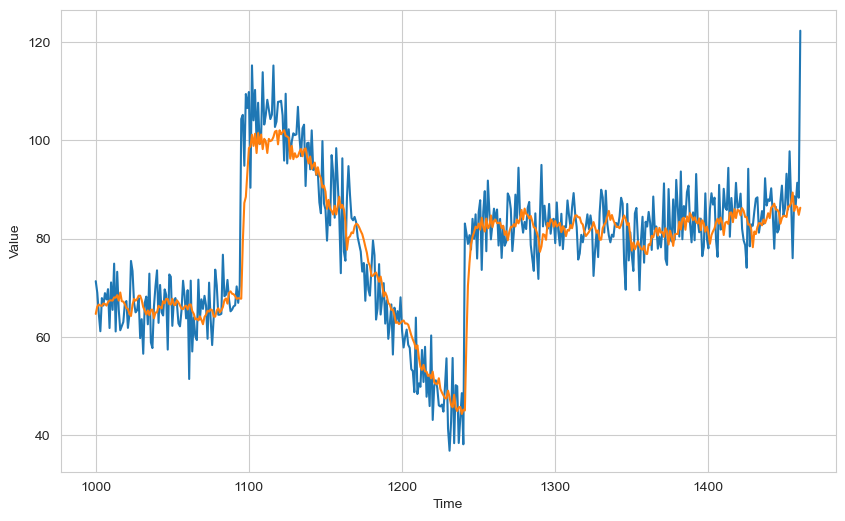

In [45]:
plt.figure(figsize=(10,6))
plot_series(time_valid,X_valid)
plot_series(time_valid,rnn_forecast)

### Fully Convolutional Forcasting

In [47]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
window_size = 64

In [48]:
train_set = seq2_seq_window_dataset(X_train,window_size,batch_size=128)

In [49]:
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None,1]))
for dilation_rate in (1,2,4,8,16,32):
    model.add(
        keras.layers.Conv1D(filters=32,kernel_size=2,strides=1,dilation_rate=dilation_rate,padding='causal',activation='relu')
    )
model.add(keras.layers.Conv1D(filters=1,kernel_size=1))

In [50]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 32)          96        
                                                                 
 conv1d_1 (Conv1D)           (None, None, 32)          2080      
                                                                 
 conv1d_2 (Conv1D)           (None, None, 32)          2080      
                                                                 
 conv1d_3 (Conv1D)           (None, None, 32)          2080      
                                                                 
 conv1d_4 (Conv1D)           (None, None, 32)          2080      
                                                                 
 conv1d_5 (Conv1D)           (None, None, 32)          2080      
                                                                 
 conv1d_6 (Conv1D)           (None, None, 1)           3

In [51]:
lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4*10**(epoch/30))

In [52]:
optimizer = keras.optimizers.Adam(learning_rate=1e-4)

In [53]:
model.compile(loss=keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

In [54]:
history = model.fit(train_set,epochs=100,callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 1s 21ms/step - loss: 42.3792 - mae: 42.8782 - lr: 1.0000e-04
Epoch 2/100
8/8 [==============================] - 0s 19ms/step - loss: 41.7593 - mae: 42.2584 - lr: 1.0798e-04
Epoch 3/100
8/8 [==============================] - 0s 17ms/step - loss: 41.2098 - mae: 41.7089 - lr: 1.1659e-04
Epoch 4/100
8/8 [==============================] - 0s 18ms/step - loss: 40.6947 - mae: 41.1939 - lr: 1.2589e-04
Epoch 5/100
8/8 [==============================] - 0s 17ms/step - loss: 40.1304 - mae: 40.6295 - lr: 1.3594e-04
Epoch 6/100
8/8 [==============================] - 0s 30ms/step - loss: 39.4055 - mae: 39.9044 - lr: 1.4678e-04
Epoch 7/100
8/8 [==============================] - 0s 19ms/step - loss: 38.3113 - mae: 38.8098 - lr: 1.5849e-04
Epoch 8/100
8/8 [==============================] - 0s 30ms/step - loss: 36.4014 - mae: 36.8998 - lr: 1.7113e-04
Epoch 9/100
8/8 [==============================] - 0s 20ms/step - loss: 33.1573 - mae: 33.6557 - lr: 1.8

8/8 [==============================] - 0s 18ms/step - loss: 6.2276 - mae: 6.7100 - lr: 0.0316
Epoch 77/100
8/8 [==============================] - 0s 19ms/step - loss: 6.8117 - mae: 7.2961 - lr: 0.0341
Epoch 78/100
8/8 [==============================] - 0s 19ms/step - loss: 6.9459 - mae: 7.4289 - lr: 0.0369
Epoch 79/100
8/8 [==============================] - 0s 21ms/step - loss: 7.0448 - mae: 7.5278 - lr: 0.0398
Epoch 80/100
8/8 [==============================] - 0s 18ms/step - loss: 7.0111 - mae: 7.4947 - lr: 0.0430
Epoch 81/100
8/8 [==============================] - 0s 20ms/step - loss: 7.5515 - mae: 8.0365 - lr: 0.0464
Epoch 82/100
8/8 [==============================] - 0s 18ms/step - loss: 8.1341 - mae: 8.6210 - lr: 0.0501
Epoch 83/100
8/8 [==============================] - 0s 17ms/step - loss: 7.2284 - mae: 7.7124 - lr: 0.0541
Epoch 84/100
8/8 [==============================] - 0s 17ms/step - loss: 8.0666 - mae: 8.5520 - lr: 0.0584
Epoch 85/100
8/8 [==============================] 

(0.0001, 0.1, 0.0, 30.0)

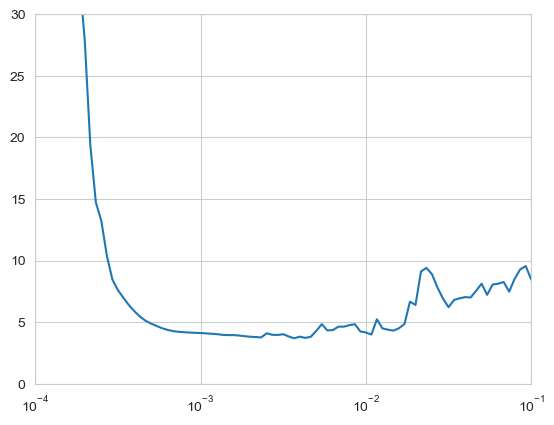

In [55]:
plt.semilogx(history.history['lr'],history.history['loss'])
plt.axis([1e-4,1e-1,0,30])

In [56]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
window_size = 64

In [57]:
train_set = seq2_seq_window_dataset(X_train,window_size,batch_size=128)
valid_set = seq2_seq_window_dataset(X_valid,window_size,batch_size=128)

In [58]:
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None,1]))
for dilation_rate in (1,2,4,8,16,32):
    model.add(
        keras.layers.Conv1D(filters=32,kernel_size=2,strides=1,dilation_rate=dilation_rate,padding='causal',activation='relu')
    )
model.add(keras.layers.Conv1D(filters=1,kernel_size=1))

In [59]:
optimizer = keras.optimizers.Adam(learning_rate=3e-4)

In [60]:
model.compile(loss=keras.callbacks.EarlyStopping(patience=50))
model.compile(loss=keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

model_checkpoint = keras.callbacks.ModelCheckpoint("my_checkpoint.h5",save_best_only=True)
history = model.fit(train_set,epochs=500,validation_data=valid_set,
                   callbacks=[early_stopping,model_checkpoint])

Epoch 1/500
8/8 [==============================] - 2s 92ms/step - loss: 41.7879 - mae: 42.2867 - val_loss: 76.0358 - val_mae: 76.5358
Epoch 2/500
8/8 [==============================] - 0s 37ms/step - loss: 40.1624 - mae: 40.6613 - val_loss: 73.1667 - val_mae: 73.6667
Epoch 3/500
8/8 [==============================] - 0s 37ms/step - loss: 38.4724 - mae: 38.9712 - val_loss: 69.0778 - val_mae: 69.5778
Epoch 4/500
8/8 [==============================] - 0s 45ms/step - loss: 35.8384 - mae: 36.3371 - val_loss: 62.4473 - val_mae: 62.9473
Epoch 5/500
8/8 [==============================] - 1s 66ms/step - loss: 31.6244 - mae: 32.1227 - val_loss: 51.6656 - val_mae: 52.1654
Epoch 6/500
8/8 [==============================] - 0s 40ms/step - loss: 25.4354 - mae: 25.9322 - val_loss: 36.8267 - val_mae: 37.3237
Epoch 7/500
8/8 [==============================] - 0s 37ms/step - loss: 20.0056 - mae: 20.5005 - val_loss: 31.5899 - val_mae: 32.0871
Epoch 8/500
8/8 [==============================] - 0s 35ms/ste

8/8 [==============================] - 0s 28ms/step - loss: 3.7562 - mae: 4.2266 - val_loss: 4.2432 - val_mae: 4.7198
Epoch 64/500
8/8 [==============================] - 0s 28ms/step - loss: 3.7497 - mae: 4.2197 - val_loss: 4.2321 - val_mae: 4.7085
Epoch 65/500
8/8 [==============================] - 0s 28ms/step - loss: 3.7422 - mae: 4.2124 - val_loss: 4.2451 - val_mae: 4.7218
Epoch 66/500
8/8 [==============================] - 0s 29ms/step - loss: 3.7352 - mae: 4.2051 - val_loss: 4.2714 - val_mae: 4.7491
Epoch 67/500
8/8 [==============================] - 0s 28ms/step - loss: 3.7315 - mae: 4.2015 - val_loss: 4.2288 - val_mae: 4.7049
Epoch 68/500
8/8 [==============================] - 0s 28ms/step - loss: 3.7206 - mae: 4.1904 - val_loss: 4.2707 - val_mae: 4.7483
Epoch 69/500
8/8 [==============================] - 0s 28ms/step - loss: 3.7129 - mae: 4.1829 - val_loss: 4.2628 - val_mae: 4.7405
Epoch 70/500
8/8 [==============================] - 0s 34ms/step - loss: 3.7034 - mae: 4.1728 - 

8/8 [==============================] - 0s 28ms/step - loss: 3.3629 - mae: 3.8215 - val_loss: 4.2893 - val_mae: 4.7675
Epoch 126/500
8/8 [==============================] - 0s 28ms/step - loss: 3.3578 - mae: 3.8159 - val_loss: 4.2332 - val_mae: 4.7098
Epoch 127/500
8/8 [==============================] - 0s 28ms/step - loss: 3.3572 - mae: 3.8149 - val_loss: 4.2778 - val_mae: 4.7562
Epoch 128/500
8/8 [==============================] - 0s 28ms/step - loss: 3.3475 - mae: 3.8046 - val_loss: 4.3034 - val_mae: 4.7816
Epoch 129/500
8/8 [==============================] - 0s 28ms/step - loss: 3.3414 - mae: 3.7981 - val_loss: 4.2749 - val_mae: 4.7530
Epoch 130/500
8/8 [==============================] - 0s 31ms/step - loss: 3.3351 - mae: 3.7914 - val_loss: 4.2564 - val_mae: 4.7341
Epoch 131/500
8/8 [==============================] - 0s 32ms/step - loss: 3.3301 - mae: 3.7858 - val_loss: 4.3128 - val_mae: 4.7911
Epoch 132/500
8/8 [==============================] - 0s 32ms/step - loss: 3.3292 - mae: 3.

In [61]:
cnn_forecast = model_forcast(model,series[...,np.newaxis],window_size)

44/44 [==============================] - 1s 5ms/step


In [62]:
cnn_forecast = cnn_forecast[split_time-window_size:-1,-1,0]